<a href="https://colab.research.google.com/github/TaarMaan/Lrn2_Artamonov_Smirnov/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BA%D0%B8_%D0%BB%D0%B0%D0%B1%D0%B02_%D0%90%D1%80%D1%82%D0%B0%D0%BC%D0%BE%D0%BD%D0%BE%D0%B2_%D0%A1%D0%BC%D0%B8%D1%80%D0%BD%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!cp /content/drive/MyDrive/LrN2/archive.zip .
!unzip /content/archive.zip

Mounted at /content/drive
Archive:  /content/archive.zip
  inflating: GlobalLandTemperaturesByCity.csv  
  inflating: GlobalLandTemperaturesByCountry.csv  
  inflating: GlobalLandTemperaturesByMajorCity.csv  
  inflating: GlobalLandTemperaturesByState.csv  
  inflating: GlobalTemperatures.csv  


In [ ]:
cities = pd.read_csv('/content/GlobalLandTemperaturesByCity.csv')
rio = cities.loc[cities['City'] == 'Rio De Janeiro', ['dt','AverageTemperature']]
rio.columns = ['Date','Temp']
rio['Date'] = pd.to_datetime(rio['Date'])
rio.reset_index(drop=True, inplace=True)
rio.set_index('Date', inplace=True)

rio = rio.loc['1900':'2013-01-01']
rio = rio.asfreq('M', method='bfill')
rio.head()

,Temp
Date,
1900-01-31,25.780
1900-02-28,26.160
1900-03-31,23.868
1900-04-30,23.467
1900-05-31,22.667


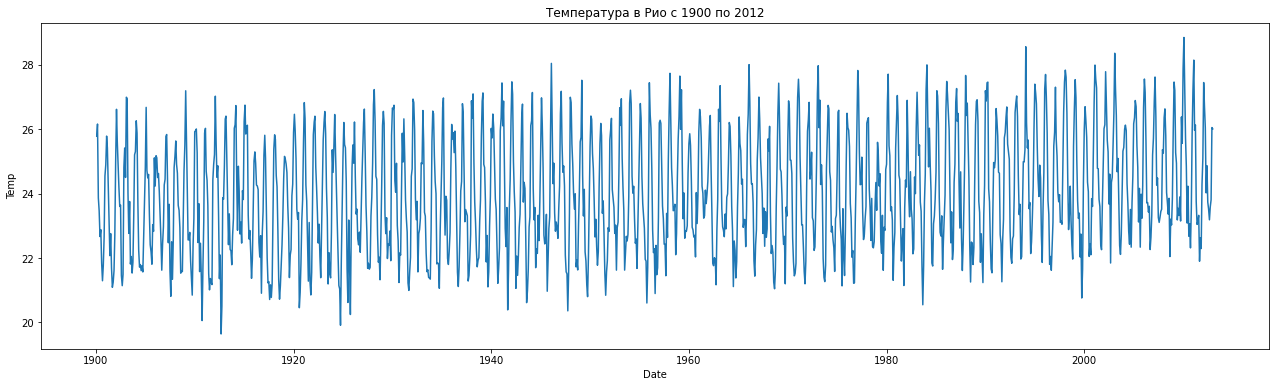

In [ ]:
plt.figure(figsize=(22,6))
sns.lineplot(x=rio.index, y=rio['Temp'])
plt.title('Температура в Рио с 1900 по 2012')
plt.show()

как меняется температура по месяцам

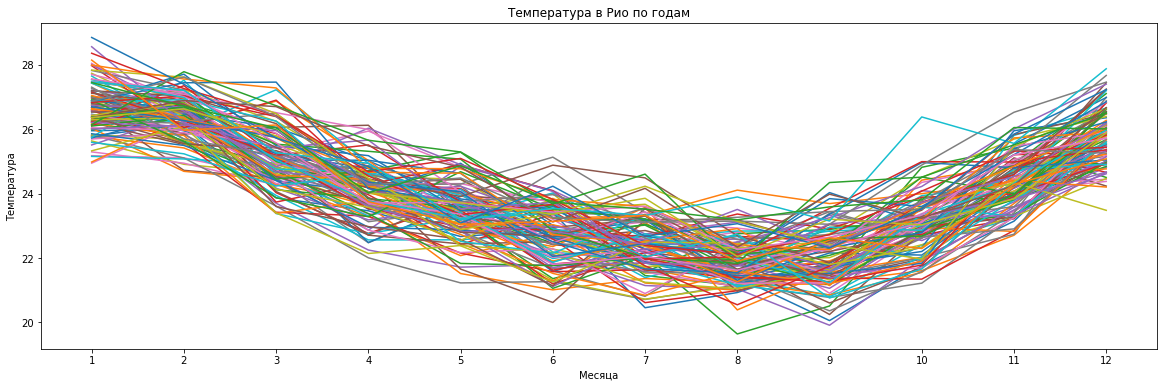

In [ ]:
rio['month'] = rio.index.month
rio['year'] = rio.index.year
pivot = pd.pivot_table(rio, values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Температура в Рио по годам')
plt.xlabel('Месяца')
plt.ylabel('Температура')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

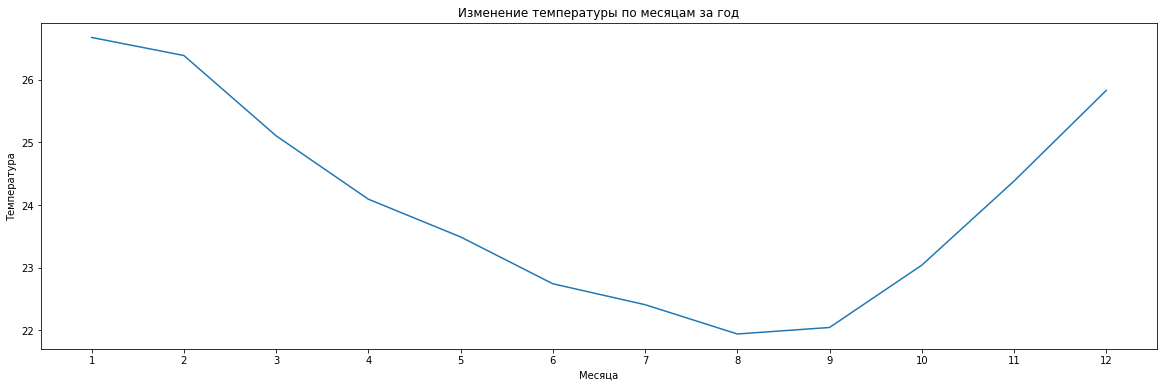

In [ ]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Изменение температуры по месяцам за год')
plt.xlabel('Месяца')
plt.ylabel('Температура')
plt.xticks([x for x in range(1,13)])
plt.show()

Более высокие температуры наблюдаются примерно в ноябре и феврале, а более низкие-в период с июля по сентябрь

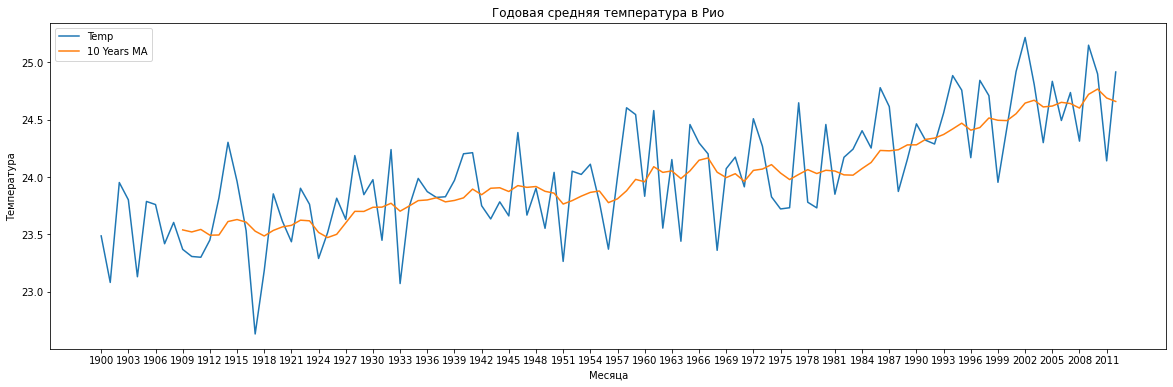

In [ ]:
year_avg = pd.pivot_table(rio, values='Temp', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['Temp'].rolling(10).mean()
year_avg[['Temp','10 Years MA']].plot(figsize=(20,6))
plt.title('Годовая средняя температура в Рио')
plt.xlabel('Месяца')
plt.ylabel('Температура')
plt.xticks([x for x in range(1900,2012,3)])
plt.show()

# разбиваем данные на тренировочный, тестовый и валидационный наборы

In [ ]:
train = rio[:-60].copy()
val = rio[-60:-12].copy()
test = rio[-12:].copy()

Убираем NaN значения и готовим данные. Готовим базовый прогноз, к которому будем стремиться

In [ ]:
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-02-29    26.362
2008-03-31    26.631
2008-04-30    25.793
2008-05-31    24.031
2008-06-30    23.713
Freq: M, Name: Temp, dtype: float64

In [ ]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'RMSE базового прогноза {round(rmse_base,4)} градусов по цельсию')

RMSE базового прогноза 1.3282 градусов по цельсию


In [ ]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    
    # создаем графики
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Изменение температуры в Рио-де-Жанейро')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Диаграмма распределения')

    plt.tight_layout()
    
    print('Результаты теста Дики-Фуллера:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Первый подход заключается в проверке ряда без каких-либо преобразований.

Результаты теста Дики-Фуллера:
Test Statistic                   -3.7599
p-value                           0.0033
Lags Used                        23.0000
Number of Observations Used    1272.0000
Critical Value (1%)              -3.4355
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


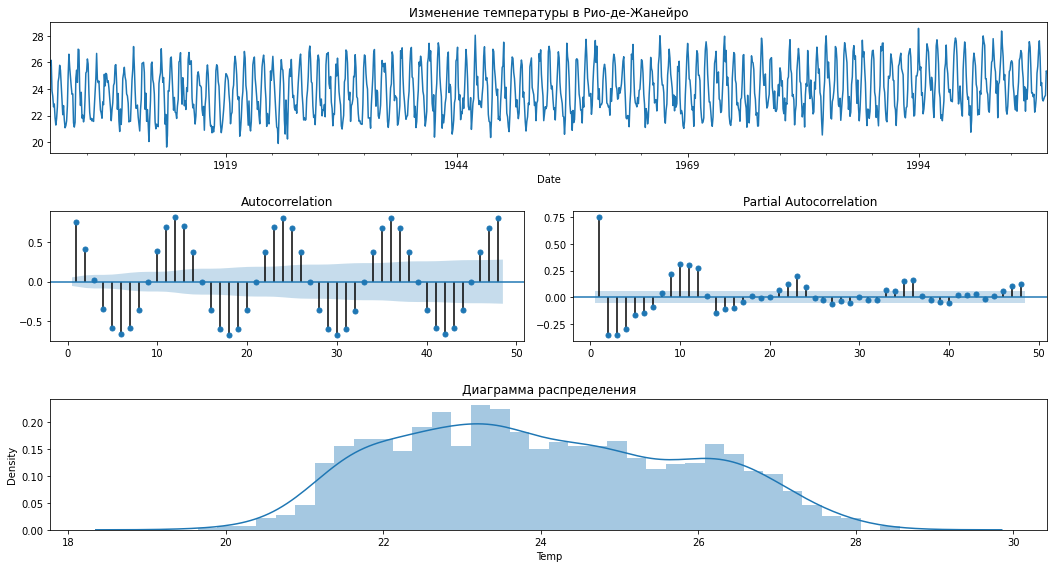

In [ ]:
check_stationarity(train['Temp'])

Результаты теста Дики-Фуллера:
Test Statistic                  -13.4631
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1260.0000
Critical Value (1%)              -3.4356
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


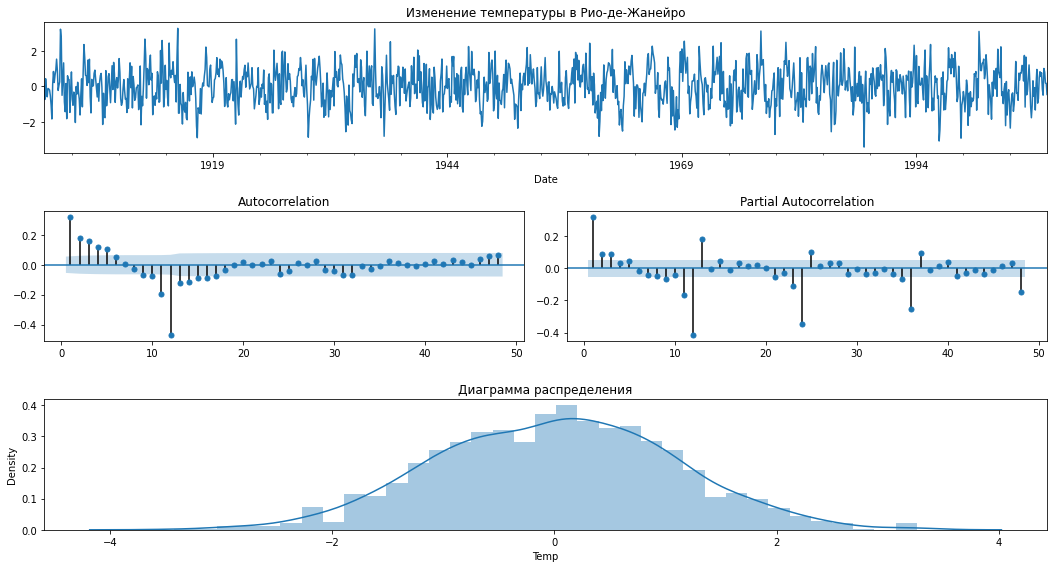

In [ ]:
check_stationarity(train['Temp'].diff(12).dropna())

In [ ]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Использование параметров SARIMA и подгонка данных
    pdq, PDQS, trend = params

    #Прогнозирование на один период вперед в наборе проверки
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

Давайте проверим это в наборе проверки

In [ ]:
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((3,0,0),(0,1,1,12),'c'))

Измерение ошибки предсказания

In [ ]:
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was 0.7874 celsius degrees
It's a decrease of -40.72% in the RMSE


Создание столбца ошибок

In [ ]:
val['Error'] = val['Temp'] - val['Pred']

In [ ]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #График текущих и прогнозируемых значений
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    #Остаточные и прогнозируемые значения
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ График остатка
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # График автокорреляции невязки
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

Нам нужно удалить некоторые столбцы, чтобы построить диаграммы

In [ ]:
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,Temp,Pred,Error
Date,,,
2008-01-31,26.362,26.921365,-0.559365
2008-02-29,26.631,26.707714,-0.076714
2008-03-31,25.793,25.489353,0.303647
2008-04-30,24.031,24.593413,-0.562413
2008-05-31,23.713,23.856252,-0.143252


Создание нового объединения набора для обучения и проверки:

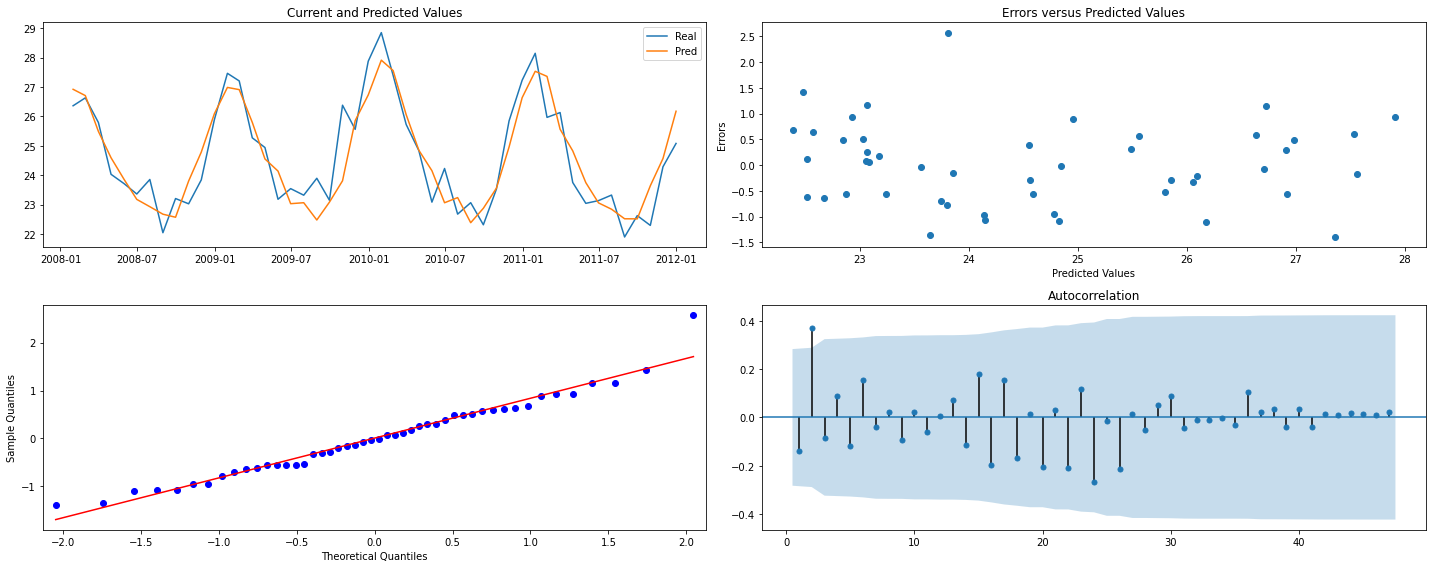

In [ ]:
plot_error(val)

Используя те же параметры подобранной модели

In [ ]:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1900-01-31    25.780
1900-02-28    26.160
1900-03-31    23.868
1900-04-30    23.467
1900-05-31    22.667
Freq: M, Name: Temp, dtype: float64

In [ ]:
model = sm.tsa.statespace.SARIMAX(future, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

In [ ]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+13))

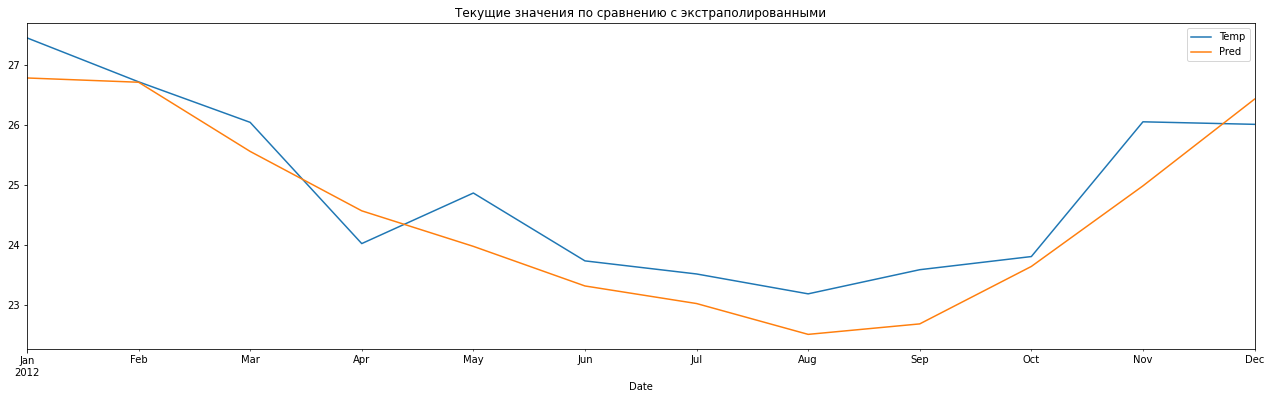

In [ ]:
test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.title('Текущие значения по сравнению с экстраполированными')
plt.show()

In [ ]:
test_baseline = test['Temp'].shift()

test_baseline[0] = test['Temp'][0]

rmse_test_base = measure_rmse(test['Temp'],test_baseline)
rmse_test_extrap = measure_rmse(test['Temp'], test['Pred'])

print(f'The baseline RMSE for the test baseline was {round(rmse_test_base,2)} celsius degrees')
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap,2)} celsius degrees')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')

The baseline RMSE for the test baseline was 1.02 celsius degrees
The baseline RMSE for the test extrapolation was 0.63 celsius degrees
That is an improvement of 37.96%


In [ ]:
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               Temp   No. Observations:                 1344
Model:             SARIMAX(3, 0, 0)x(0, 1, 1, 12)   Log Likelihood               -1483.138
Date:                            Fri, 10 Jun 2022   AIC                           2978.276
Time:                                    12:57:28   BIC                           3009.443
Sample:                                01-31-1900   HQIC                          2989.956
                                     - 12-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0064      0.001      7.638      0.000       0.005       0.008
ar.L1          0.2723      0.027   

In [ ]:
from sklearn.metrics import mean_squared_error


print('SARIMAX model MSE:{}'.format(mean_squared_error(test['Temp'],test['Pred'])))

SARIMAX model MSE:0.3996200930145111


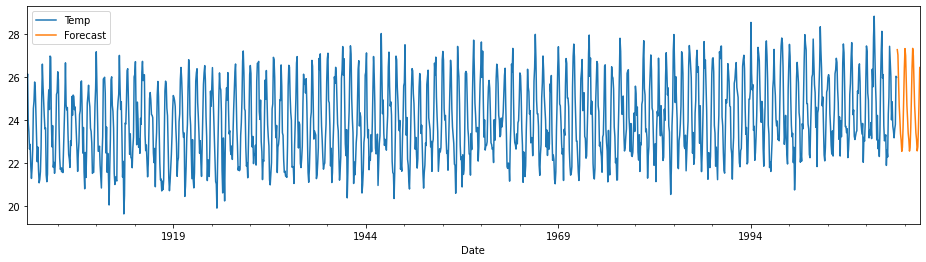

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = model = SARIMAX(rio [ 'Temp' ],order = ( 3 , 0 , 0 ),seasonal_order = ( 0 , 1 , 1 , 12 ),trend = 'c')
result = model.fit()
forecast = result.predict(start = len (rio), end = ( len (rio) - 1 ) + 3*12 , typ = 'levels' ).rename( 'Forecast' ) 
rio[ 'Temp' ].plot(figsize = ( 16 , 4 ), legend = True )
forecast.plot(legend = True )  